In [ ]:
!gdown 1EamxQYrDhAkFHtEQqWPb-00FC5XkAD-n

Downloading...
From: https://drive.google.com/uc?id=1EamxQYrDhAkFHtEQqWPb-00FC5XkAD-n
To: /content/CarTruck.zip
100% 82.1M/82.1M [00:00<00:00, 276MB/s]


In [ ]:
!unzip CarTruck.zip

Archive:  CarTruck.zip
replace CarTruck/test/Car/09847.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from tensorflow.python.ops.math_ops import truncate_div
# Imports
import os, warnings

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'CarTruck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    #validation_split=0.3;
    #subset='training',
    #seed=1
)
ds_valid_ = image_dataset_from_directory(
    'CarTruck/val',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    #validation_split=0.3;
    #subset='validation',
    #seed=1
)
ds_test_ = image_dataset_from_directory(
    'CarTruck/test',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=truncate_div,
)


Found 8134 files belonging to 2 classes.
Found 1016 files belonging to 2 classes.
Found 1018 files belonging to 2 classes.


In [ ]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test= (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    #CNN
    layers.Conv2D(filters=32, kernel_size=3,activation='relu'), # activation is None
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3,activation='relu'), # activation is None
    layers.MaxPooling2D(),
    layers.Conv2D(filters=128, kernel_size=3,activation='relu'), # activation is None
    layers.MaxPooling2D(),
    layers.Conv2D(filters=256, kernel_size=3,activation='relu'), # activation is None
    layers.MaxPooling2D(),

    #Classification
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=5,
    verbose=1,
)

Epoch 1/5
128/128 [==============================] - 25s 62ms/step - loss: 0.6542 - binary_accuracy: 0.5894 - val_loss: 0.6027 - val_binary_accuracy: 0.6811
Epoch 2/5
128/128 [==============================] - 5s 42ms/step - loss: 0.5766 - binary_accuracy: 0.7151 - val_loss: 0.5702 - val_binary_accuracy: 0.7303
Epoch 3/5
128/128 [==============================] - 5s 37ms/step - loss: 0.5314 - binary_accuracy: 0.7569 - val_loss: 0.5146 - val_binary_accuracy: 0.7835
Epoch 4/5
128/128 [==============================] - 5s 37ms/step - loss: 0.4934 - binary_accuracy: 0.7910 - val_loss: 0.4853 - val_binary_accuracy: 0.8150
Epoch 5/5
128/128 [==============================] - 5s 36ms/step - loss: 0.4483 - binary_accuracy: 0.8221 - val_loss: 0.4525 - val_binary_accuracy: 0.8297


In [ ]:
model.save('./Models/my_model.keras')

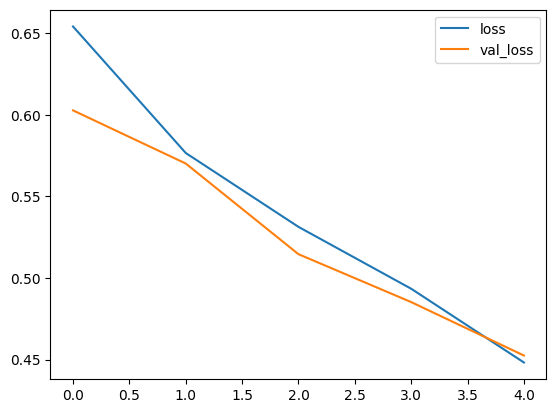

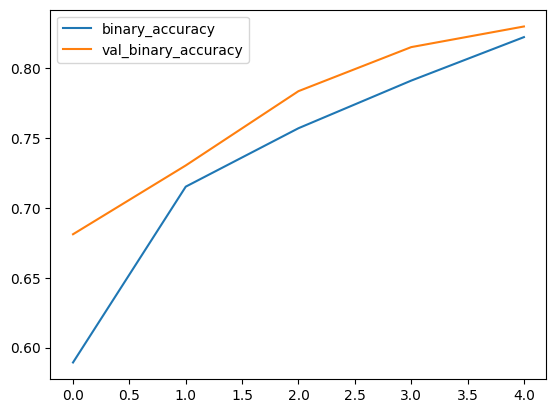

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

16/16 [==============================] - 1s 27ms/step - loss: 0.4807 - binary_accuracy: 0.8202
Test accuracy: 0.820
Test loss: 0.481


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pretrained_base = MobileNetV2(include_top=False,weights='imagenet',input_shape=(128,128,3))
pretrained_base.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
callbacks = [

    tf.keras.callbacks.ModelCheckpoint(
        './Models/CheckPoint/CarTruckMobile.ckpt',
        monitor='val_binary_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1,

    ),

]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model2 = keras.Sequential([
    pretrained_base,
    #Classification
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history2 = model2.fit(
    ds_train,
    validation_data=ds_valid,
    callbacks=callbacks,
    epochs=50,
    verbose=1,
)

Epoch 1/50
127/128 [============================>.] - ETA: 0s - loss: 0.0877 - binary_accuracy: 0.9845
Epoch 1: val_binary_accuracy improved from 0.90453 to 0.90748, saving model to ./Models/CheckPoint/CarTruckMobile.ckpt
128/128 [==============================] - 9s 45ms/step - loss: 0.0876 - binary_accuracy: 0.9845 - val_loss: 0.3390 - val_binary_accuracy: 0.9075
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 0.0820 - binary_accuracy: 0.9854
Epoch 2: val_binary_accuracy did not improve from 0.90748
128/128 [==============================] - 4s 34ms/step - loss: 0.0819 - binary_accuracy: 0.9854 - val_loss: 0.3140 - val_binary_accuracy: 0.9055
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.0754 - binary_accuracy: 0.9871
Epoch 3: val_binary_accuracy did not improve from 0.90748
128/128 [==============================] - 4s 35ms/step - loss: 0.0753 - binary_accuracy: 0.9871 - val_loss: 0.3558 - val_binary_accuracy: 0.9045
Epoch 4/50
127/128

##Save Model

In [ ]:
model2.save('./Models/my_model2.keras')

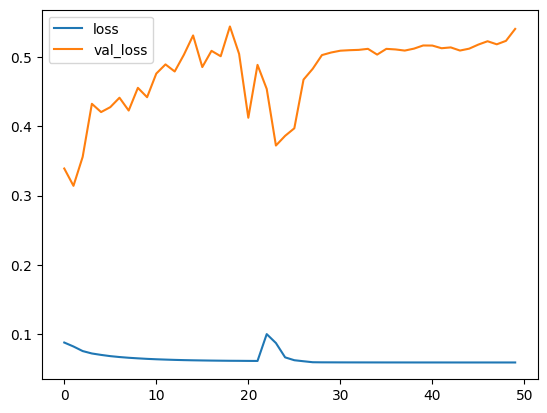

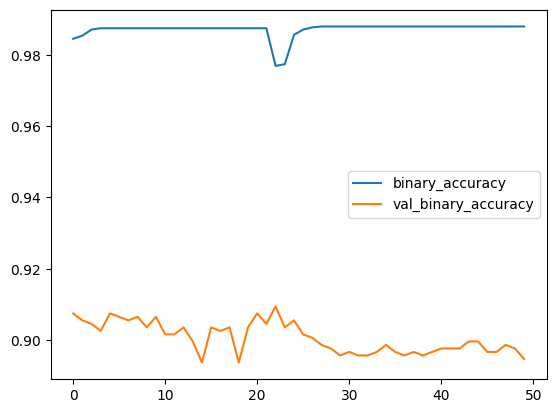

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history2.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
test_loss, test_acc = model2.evaluate(ds_test)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

16/16 [==============================] - 1s 34ms/step - loss: 0.3949 - binary_accuracy: 0.9037
Test accuracy: 0.904
Test loss: 0.395


#Load weight

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pretrained_base = MobileNetV2(include_top=False,weights='imagenet',input_shape=(128,128,3))
pretrained_base.trainable = False

from tensorflow import keras
from tensorflow.keras import layers

model2_weight = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


model2_weight.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


In [ ]:
test_loss, test_acc = model2_weight.evaluate(ds_test)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

16/16 [==============================] - 2s 33ms/step - loss: 0.8831 - binary_accuracy: 0.5442
Test accuracy: 0.544
Test loss: 0.883


In [ ]:
# Loads the weights
model2_weight.load_weights('./Models/CheckPoint/CarTruckMobile.ckpt')

#Load Model

In [ ]:
import tensorflow as tf

new_model = tf.keras.models.load_model('./Models/my_model.keras')

In [ ]:
test_loss, test_acc = new_model.evaluate(ds_test)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

16/16 [==============================] - 1s 14ms/step - loss: 0.4807 - binary_accuracy: 0.8202
Test accuracy: 0.820
Test loss: 0.481


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model file.
with open('./Models/my_model.tflite', "wb") as f:
  f.write(tflite_model)